# Android Data from PlayStore

In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# load data
%run ./Preprocessing.ipynb
df = get_data();
orig_df = df.copy();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
name               10841 non-null object
category           10841 non-null object
rating             9367 non-null float64
reviews            10841 non-null object
size               10841 non-null object
installs           10841 non-null object
type               10840 non-null object
price              10841 non-null object
content_rating     10840 non-null object
genres             10841 non-null object
last_updated       10841 non-null object
version            10833 non-null object
android_version    10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
Number of duplicate entries : 1181
Original values : ['Free' 'Paid' nan]
Unique genres before preprocessing : 118
 Apps with more than one genre : 393 
Unique genres : 48
Oldest updated app : 2010
Longest app name with 25 words : 591 housing transactions - renting houses, middle-class houses, new cases, 

# Science

We transformed the problem in a classification one. Now rating can be *poor* (< 4) and *excellent* (>=4). 

We achieved the following : 
- 70% with RandomForest(n_estimators = 100)

Notes : 
- RandomForest clearly tends to overfit. Reducing the complexity of the tree algorithm doesn't improve accuracy in cross validation by no means. 
    + this may mean that the model is too complex. reducing the number of features took into account can help
**Next thing** : We should try adding or changing the features of data, and try more values for the hyperparameters of the algorithm

In [194]:
df = orig_df.copy()

In [195]:
features = df.columns.values.tolist()
print(features)

['category', 'rating', 'reviews', 'size', 'installs', 'type', 'price', 'content_rating', 'genres', 'version', 'android_version', 'price_rounded', 'last_updated_days', 'last_updated_year', 'last_updated_month', 'last_updated_day', 'last_updated_month_sin', 'last_updated_month_cos', 'name_wc']


In [196]:
pre_features = ['category', 'size', 'type', 'price', 'content_rating', 'genres', 'android_version', 'name_wc']
post_features = [feature for feature in df.columns.values if feature not in pre_features]
log_features = ['reviews', 'installs', 'name_wc', 'size', 'rating']
cat_features = ['category', 'type', 'content_rating', 'genres']

In [197]:
use_categories = True
if use_categories:
    pre_features = list(set(pre_features + cat_features))
    post_features = list(set(post_features + cat_features))
else:
    pre_features = [ft for ft in pre_features if ft not in cat_features]
    post_features = [ft for ft in post_features if ft not in cat_features]
print('Predictors are : %s' % pre_features)

Predictors are : ['genres', 'category', 'content_rating', 'name_wc', 'price', 'size', 'android_version', 'type']


In [198]:
use_log = False
if use_log:
    df[log_features] = np.log(df[log_features])

In [199]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state = 42)
train.shape
test.shape

(7726, 19)

(1932, 19)

## Preprocessing
Missing values and outliers removal

In [200]:
from OutlierIQR import OutlierIQR
to_remove_outliers = False
outliers_cols = ['installs']
if to_remove_outliers:
    odetector = OutlierIQR()
    odetector.fit(train, columns = ['installs'])
    train = odetector.transform(train)
    test = odetector.transform(test)
train.shape
test.shape

(7726, 19)

(1932, 19)

In [201]:
# Impute missing values using the median so we will not treat them as outliers later
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = -1, strategy='median')
missing_features = ['android_version', 'size']
imp.fit(train[missing_features])
train.loc[:, missing_features] = imp.transform(train[missing_features])
test.loc[:, missing_features] = imp.transform(test[missing_features])

SimpleImputer(copy=True, fill_value=None, missing_values=-1,
       strategy='median', verbose=0)

/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Starting machine learning
Split data into predictors and labels, both for train and test

In [202]:
def split_samples_labels(df, label_column, keep_features = None):
    Y = df[label_column].values
    X = df.drop(columns = label_column)
    if keep_features is not None:
        X = X[keep_features]
    bins = [Y.min(), np.percentile(Y, 70), Y.max()]
    Y[Y < bins[1]] = 0
    Y[Y >= bins[1]] = 1
    return X, Y

In [203]:
x_train, y_train = split_samples_labels(train, 'installs', keep_features=pre_features)
x_test, y_test = split_samples_labels(test, 'installs', keep_features=pre_features)
x_train.shape
x_test.shape

(7726, 8)

(1932, 8)

## Additional enhancements
Oversampling and scaling

In [204]:
len(y_train[y_train==1])
len(y_train[y_train==0])

2691

5035

In [206]:
# the dataset is rather imbalanced, which will skew the results. So we reduce the number of big rating examples
# we can also try upsampling the small rating examples
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
upsample = False
downsample = False
if upsample:
    sampler = RandomOverSampler(random_state = 42)
    x_train, y_train = sampler.fit_resample(x_train,y_train)
elif downsample :
    sampler = RandomUnderSampler(random_state=42)
    x_train, y_train = sampler.fit_resample(x_train, y_train)
len(y_train[y_train==1])
len(y_train[y_train==0])

2691

5035

In [207]:
from sklearn import preprocessing
# scale data if needed. forests and trees don't need it. Others do. 
scale = True
if scale:
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## Tuning models hyperparameters

In [208]:
from sklearn import ensemble, tree, svm, neighbors
from sklearn.model_selection import cross_val_score
# KNN - best is n_neighbors = 4
# KNN is very much affected by random upsampling. because many entries are duplicates
knn = neighbors.KNeighborsClassifier()
scores = []
fit_grid = False
if fit_grid:
    try_neighbors = range(1,11)
    for n_neighbors in try_neighbors:
        knn.n_neighbors = n_neighbors;
        val_scores = cross_val_score(knn, x_train, y_train, cv = 3 )
        scores.append(val_scores.mean())
    plt.plot(try_neighbors, scores, 'b*-');
else:
    knn.n_neighbors = 4
    print('Validation score : %.2f' % cross_val_score(knn, x_train, y_train, cv = 3).mean());
    knn.fit(x_train, y_train);
    print('Test score : %.2f' % knn.score(x_test, y_test));

Validation score : 0.71


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

Test score : 0.72


In [160]:
# SVC
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(kernel = 'rbf', random_state=42, probability = True,
             C = 1, tol = .001, gamma = 9)
fit_grid = False
if fit_grid:
    params = [{'kernel' : ['rbf'],
            'gamma' : ['scale'],
            'C' : [1],
            'tol' : [0.001],
            'gamma' : [9]}]
    grid = GridSearchCV(estimator = svc,
                  param_grid = params,
                  cv = 3, iid = False)
    grid.fit(x_train, y_train)
    grid.score(x_test, y_test)
else :
    print('Validation score %.2f' % cross_val_score(svc, x_train, y_train, cv = 5).mean())
    svc.fit(x_train, y_train)
    print('Test score %.2f' % svc.score(x_train, y_train))

Validation score 0.68


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=9, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Test score 0.72


In [57]:
grid.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=9, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [209]:
# Random Forest
rf =  ensemble.RandomForestClassifier(n_estimators=100, random_state = 42,
                                       min_impurity_decrease=0, min_samples_leaf=1,
                                        max_features = 3)
grid_fit = False
if grid_fit:
    params = {'max_features' : [3],
             'min_samples_leaf' : [1]}
    grid = GridSearchCV(estimator = rf,
                  param_grid = params,
                  cv = 5, iid = False, return_train_score=True)
    grid.fit(x_train, y_train)
    grid.score(x_test, y_test)
else:
    rf.fit(x_train, y_train)
    rf.score(x_train, y_train)
    rf.score(x_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.9628527051514367

0.7272256728778468

In [60]:
grid.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=9, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [210]:
dt = tree.DecisionTreeClassifier(min_impurity_decrease=0, min_samples_leaf= 4, max_features=4, random_state=42)
grid_fit = False
if grid_fit:
    params = {'max_features' : [1,2,3,4,5,6,7,8],
              'min_samples_leaf' : [2,3,4,5],
              'min_impurity_decrease' : [0,0.01]
             }
    grid = GridSearchCV(estimator = dt,
                  param_grid = params,
                  cv = 5, iid = False, return_train_score=True)
    grid.fit(x_train, y_train)
else:
    dt.fit(x_train, y_train)
    dt.score(x_train, y_train)
    dt.score(x_test, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

0.8264302355682113

0.7148033126293996

In [69]:
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [211]:
from model import Model, ModelsBenchmark
from sklearn.ensemble import VotingClassifier

models = [svc, rf, dt, knn]
# add voting method
estimators = [ (model.__class__.__name__,model) for model in models]
voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
models.append(voting_clf)
# benchmark between all models so far
bench = ModelsBenchmark(models);
bench.fit(x_train, y_train)
bench.score(x_train, y_train)
bench.score(x_test, y_test)
bench._scores

[(0.9628527051514367,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.9011131245146259,
  VotingClassifier(estimators=[('SVC', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=9, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True,
    tol=0.001, verbose=False)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=Tru...ki',
             metric_params=None, n_jobs=None, n_neighbors=4, p=2,
             weights='uniform'))],
           flatten_transform=None, n_jobs=-1, voting='soft', weights=None)),
 (0.8503753559409785, SVC(C

[(0.7401656314699793,
  VotingClassifier(estimators=[('SVC', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=9, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True,
    tol=0.001, verbose=False)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=Tru...ki',
             metric_params=None, n_jobs=None, n_neighbors=4, p=2,
             weights='uniform'))],
           flatten_transform=None, n_jobs=-1, voting='soft', weights=None)),
 (0.7272256728778468,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.7194616977225673,
  KNe

[(0.7401656314699793,
  VotingClassifier(estimators=[('SVC', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=9, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True,
    tol=0.001, verbose=False)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=Tru...ki',
             metric_params=None, n_jobs=None, n_neighbors=4, p=2,
             weights='uniform'))],
           flatten_transform=None, n_jobs=-1, voting='soft', weights=None)),
 (0.7272256728778468,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.7194616977225673,
  KNe

# Evaluating models

In [78]:
# reduce dimensionality to be able to plot data
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 42);
    
def reduce_dimensions(X, fit=False):
    if fit:
        pca.fit(X)
    return pca.transform(X)


[(0.7401656314699793,
  VotingClassifier(estimators=[('SVC', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=9, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True,
    tol=0.001, verbose=False)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=Tru...ki',
             metric_params=None, n_jobs=None, n_neighbors=4, p=2,
             weights='uniform'))],
           flatten_transform=None, n_jobs=-1, voting='soft', weights=None)),
 (0.7272256728778468,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.7194616977225673,
  KNe

Text(0.5, 1.0, 'Train Data')

Text(0.5, 0, 'x_0')

Text(0, 0.5, 'x_1')

Text(0.5, 1.0, 'Test Data')

Text(0.5, 0, 'x_0')

Text(0, 0.5, 'x_1')

Text(0.5, 1.0, 'Test')

Text(0.5, 15.0, 'Predicted')

Text(455.608695652174, 0.5, 'Actual')

Text(0.5, 1.0, 'Train')

Text(0.5, 15.0, 'Predicted')

Text(666.913043478261, 0.5, 'Actual')

[[4813  222]
 [ 542 2149]]
Train Accuracy : 0.90 
Test Accuracy : 0.74 


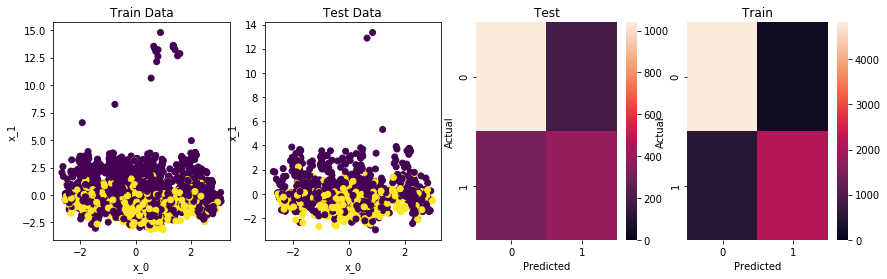

In [79]:
# print and plot metrics for the best one
from sklearn.metrics import confusion_matrix
bench.fit(x_train, y_train)
bench.score(x_test, y_test)
clf = bench._sorted[0]
fig, axs = plt.subplots(nrows = 1, ncols = 4);
fig.subplots_adjust(right = 2);
x_plot = reduce_dimensions(x_train, fit = True)
axs[0].scatter(x_plot[:, 0], x_plot[:,1], c = y_train);
axs[0].set_title('Train Data');
axs[0].set_xlabel('x_0');
axs[0].set_ylabel('x_1');
x_plot = reduce_dimensions(x_test)
axs[1].scatter(x_plot[:, 0], x_plot[:,1], c = y_test);
axs[1].set_title('Test Data');
axs[1].set_xlabel('x_0');
axs[1].set_ylabel('x_1');
test_cnf_matrix = confusion_matrix(y_test, clf.predict(x_test))
sns.heatmap(test_cnf_matrix, ax = axs[2], vmin = 0);
axs[2].set_title('Test');
axs[2].set_xlabel('Predicted');
axs[2].set_ylabel('Actual');
train_cnf_matrix = confusion_matrix(y_train, clf.predict(x_train))
sns.heatmap(train_cnf_matrix, ax = axs[3], vmin = 0);
axs[3].set_title('Train');
axs[3].set_xlabel('Predicted');
axs[3].set_ylabel('Actual');
print(train_cnf_matrix)
print('Train Accuracy : %.2f ' % clf.score(x_train, y_train))
print('Test Accuracy : %.2f ' % clf.score(x_test, y_test))

Below we make predictions on 2-dimensional data and plot the points labeled wrong.   
Currently, below part has a bug and doesn't run correctly.

In [92]:
# trying to solve the bug below, set the max_features attribute to 2
# rf_plot = rf
# rf_plot.max_features = 2
# dt_plot = dt
# dt_plot.max_features = 2
# vot_plot = voting_clf
# vot_plot.estimators = [svc, knn, rf_plot, dt_plot]
# clf = vot_plot

TypeError: zip argument #1 must support iteration

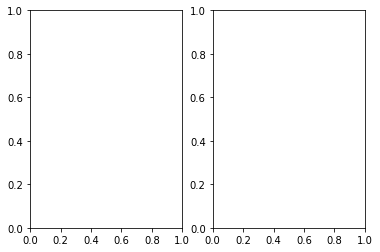

In [93]:
# plot both labels separately and our predictions on them
fig, axs = plt.subplots(nrows = 1, ncols = 2)
x_plot_train = reduce_dimensions(x_train, fit=True)
y_plot_train = y_train
x_plot_test = reduce_dimensions(x_test)
y_plot_test = y_test
clf.fit(x_plot_train,y_plot_train)
x_plot = x_plot_test
y_plot = y_plot_test
y_pred = clf.predict(x_plot)
fig.subplots_adjust(right = 2)
labeled_0 = x_plot[y_plot == 0]
scatter = axs[0].scatter(labeled_0[:,0], labeled_0[:, 1], c = y_pred[y_plot ==  0], )
fig.colorbar(scatter, ax = axs[0])
axs[0].set_title('Points with true label 0 ')
labeled_0_acc = (y_pred == 0) == (y_plot == 0).sum() / len(y_pred)
# print('Accuracy for true label 0 : %.3f' % labeled_0_acc)
labeled_1 = x_plot[y_plot == 1]
scatter = axs[1].scatter(labeled_1[:,0], labeled_1[:, 1], c = y_pred[y_plot == 1] )
fig.colorbar(scatter, ax = axs[1])
axs[1].set_title('Points with true label 1 ')

In [25]:
y_pred == 0

array([ True, False,  True, ...,  True, False,  True])

In [94]:
# print some correctly and incorrectly labeled data
from random import randint
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
# correct = x_test[y_pred == y_test]
# incorrect = x_test[~(y_pred == y_test)]

columns = df.columns.values
def get_samples(x, y_true, y_pred, sample_type = 'correct', count = 5):
    mask = (y_pred == y_true)
    if sample_type == 'incorrect':
        mask = ~mask
    x = x[mask]
    y_pred = y_pred[mask]
    y_true = y_true[mask]
    df = pd.DataFrame(columns=[*columns , 'predicted', 'true'])
    if len(x) == 0:
        return df
    for _ in range(count):
        idx = randint(0, len(x)) 
        dct = {}
        dct['predicted'] = y_pred[idx]
        dct['true'] = y_true[idx]
        for i in range(x.shape[1]):
            dct[df.columns.values[i]] = x[idx][i]
        df = df.append(dct,
                       ignore_index=True)
    return df

print("====Correct samples =====")
get_samples(x_test, y_test, y_pred, sample_type='correct') 
print("====Incorrect samples =====")
get_samples(x_test, y_test, y_pred, sample_type='incorrect') 

TypeError: zip argument #1 must support iteration

In [95]:
# Visualisation of the decision tree created by the algorithm, for fun and insight
import graphviz
from sklearn.tree import export_graphviz
clf = Model(dt)
clf.compute_scores((x_train, y_train), (x_test, y_test))
clf.model.tree_.max_depth
dot_data = export_graphviz(clf.model,
                           out_file=None,
                           feature_names=pre_features,
                           class_names=['fair', 'excellent'],
                           filled=True,
                           rounded=True)
graph = graphviz.Source(dot_data)
graph

(0.8151695573388558, 0.7261904761904762)

24

# Neural network model

In [105]:
import keras
from keras import layers

num_classes = 2
input_shape = x_train.shape[1]
model = keras.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.BatchNormalization(input_shape=(input_shape,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [106]:
model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

In [108]:
from keras.utils import to_categorical
no_epochs = 20
batch_size = 1024
history = model.fit(x_train, to_categorical(y_train), validation_split=.3, batch_size = batch_size, epochs = no_epochs )

Train on 5408 samples, validate on 2318 samples
Epoch 1/20
5408/5408 [==============================] - 1s 120us/step - loss: 0.5249 - acc: 0.7313 - val_loss: 0.5567 - val_acc: 0.7066
Epoch 2/20
5408/5408 [==============================] - 1s 127us/step - loss: 0.5409 - acc: 0.7167 - val_loss: 0.5712 - val_acc: 0.6924
Epoch 3/20
5408/5408 [==============================] - 1s 130us/step - loss: 0.5358 - acc: 0.7265 - val_loss: 0.5656 - val_acc: 0.6915
Epoch 4/20
5408/5408 [==============================] - 1s 131us/step - loss: 0.5195 - acc: 0.7361 - val_loss: 0.5372 - val_acc: 0.7127
Epoch 5/20
5408/5408 [==============================] - 1s 133us/step - loss: 0.5233 - acc: 0.7389 - val_loss: 0.5518 - val_acc: 0.7032
Epoch 6/20
5408/5408 [==============================] - 1s 133us/step - loss: 0.5239 - acc: 0.7387 - val_loss: 0.5360 - val_acc: 0.7252
Epoch 7/20
5408/5408 [==============================] - 1s 135us/step - loss: 0.5178 - acc: 0.7382 - val_loss: 0.5311 - val_acc: 0.7282


In [109]:
model.evaluate(x_test, to_categorical(y_test))

1932/1932 [==============================] - 0s 93us/step


[0.5574863825155341, 0.7194616978459724]

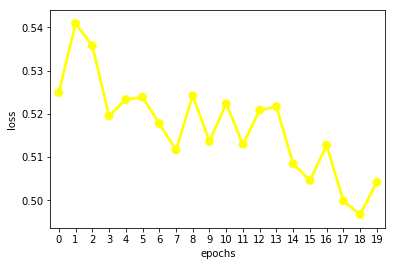

In [110]:
df = pd.DataFrame({'epochs':history.epoch, 'loss': history.history['loss'], 
                   'validation_loss': history.history['val_loss']
                  })
g = sns.pointplot(x="epochs", y="loss", data=df, fit_reg=False, color = 'yellow')
# g = sns.pointplot(x="epochs", y="validation_loss", data=df, fit_reg=False, color='red')

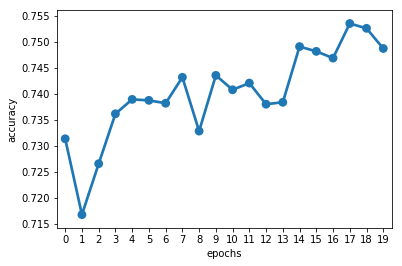

In [111]:
import seaborn as sns
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc']
                   , 'validation_accuracy': history.history['val_acc']
                  })
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
# g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

# Model voting 
Maybe below weights will help raise model accuracy

In [338]:
from sklearn.ensemble import VotingClassifier
from collections import Counter
estimators = [
    ('svc', svm.SVC(kernel ='rbf', random_state=42, probability=True)),
    ('rf', ensemble.RandomForestClassifier(n_estimators=100, min_impurity_decrease=0, min_samples_leaf=1, random_state=42)),
    ('knn', neighbors.KNeighborsClassifier(n_neighbors=2))
]
weights = [112, 89, 1]
voting_classifier = VotingClassifier(estimators=estimators, voting='soft', weights=weights, n_jobs=-1)
voting_classifier.fit(x_train, y_train)
confidence = voting_classifier.score(x_test, y_test)
predictions = voting_classifier.predict(x_test)
print('accuracy: %s %s' % (confidence, weights))
print('predictions:', Counter(predictions))

VotingClassifier(estimators=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False)), ('rf', RandomForestClassifier(bootstrap=True,...ki',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=-1, voting='soft',
         weights=[112, 89, 1])

accuracy: 0.6863517060367454 [112, 89, 1]
predictions: Counter({0: 894, 1: 630})
